In [1]:
from matplotlib import pyplot as plt
import numpy as np
from time import time
from os.path import abspath, join
import sys
from glob import glob
import vaex
from tqdm import tqdm
from hammer import vel
from scipy.stats import median_abs_deviation as mad_func
root_dir = abspath(join('..', '..'))
root_data_dir = join(root_dir, 'Data')
sys.path.append(root_dir)

In [2]:
from utils import (plot_corner, plot_chain, plot_fit_w, style, get_params,
                   get_initial_position_normal, get_data, generate_init)
style()

In [3]:
w_dir_path = join(root_data_dir, 'MCMC-no', 'mock', 'data', 'z')
z_dir_path = join(root_data_dir, 'MCMC-no', 'mock', 'data', 'z')
w_dir_path, z_dir_path

('/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/z',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/z')

In [4]:
ind = 0
wdata = get_data(w_dir_path, ind, tipe="w")
files = glob(join(w_dir_path, "w*"))
files.sort()
name_pred = files[ind].split(
    "/")[-1].split(".")[0].replace("w", "pred") + ".npy"
name_phi = files[ind].split("/")[-1].split(".")[0].replace("w", "phi") + ".npy"
name_pred, name_phi

('pred_162.npy', 'phi_162.npy')

# Fit w

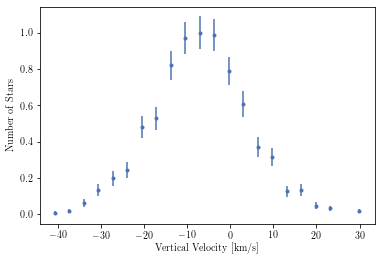

In [5]:
wmid, wnum, werr = wdata

plt.errorbar(wmid, wnum, yerr=werr, fmt='.')
plt.xlabel("Vertical Velocity [km/s]")
plt.ylabel("Number of Stars")
plt.show()

In [6]:
psi, locs, scales, labels, labs = generate_init("kin")
[(lb, l, l+s) for lb,  l, s in zip(labels, locs, scales)]

[('$w_0$', -15.0, 0.0),
 ('$\\log \\sigma_{w,1}$', 0.0, 3.4011973816621555),
 ('$\\log \\sigma_{w,2}$', 0.0, 3.4011973816621555),
 ('$\\log a_1$', 0.0, 2.0),
 ('$\\log a_2$', 0.0, 2.0),
 ('$\\log \\Phi$', 0.0, 10.0)]

In [12]:
ndim = len(labs)
nwalker = 10*ndim
p0 = None
while True:
  p0 = vel.generate_p0(nwalker, locs, scales)
  indexes = list(range(ndim))
  prob0 = vel.log_prob_par(p0, wdata, locs, scales)
  mask = np.isinf(prob0[:, 0])
  p0 = p0[~mask]
  if p0.shape[0] % 2 != 0:
    p0 = np.append(p0, p0[0][None, :], axis=0)
  p0.shape
  if len(p0) > 2*ndim:
    break
p0.shape

(20, 6)

In [13]:
vel.log_prob_par(p0, wdata, locs, scales)

array([[-1.12924206e+01, -4.61363600e+03, -4.62492842e+03],
       [-1.11224013e+01, -3.71571361e+03, -3.72683602e+03],
       [-1.08627897e+01, -1.37344095e+03, -1.38430374e+03],
       [-1.11798119e+01, -8.11331930e+02, -8.22511742e+02],
       [-1.13708979e+01, -1.03670315e+04, -1.03784024e+04],
       [-1.07650864e+01, -5.49588313e+03, -5.50664822e+03],
       [-1.08699172e+01, -1.15763594e+03, -1.16850586e+03],
       [-1.11535374e+01, -4.14272408e+03, -4.15387762e+03],
       [-1.11635718e+01, -5.60028015e+04, -5.60139651e+04],
       [-1.10793986e+01, -1.26367174e+04, -1.26477968e+04],
       [-1.14368313e+01, -4.33276858e+03, -4.34420541e+03],
       [-1.09335232e+01, -1.20404688e+03, -1.21498041e+03],
       [-1.08022425e+01, -3.27299650e+03, -3.28379874e+03],
       [-1.09813522e+01, -8.98698921e+02, -9.09680273e+02],
       [-1.07579470e+01, -7.83579934e+03, -7.84655729e+03],
       [-1.07768642e+01, -2.13935786e+03, -2.15013472e+03],
       [-1.08936588e+01, -2.59220177e+03

In [14]:
indexes = list(range(ndim))

for _ in tqdm(range(5)):
    chain = vel.mcmc(5000, p0, wdata, locs, scales, parallel=True, verbose=True)
    locs_normal, scales_normal = get_initial_position_normal("kin", 
                                                              chain=chain[1000:], 
                                                              indexes=indexes)
    while True:
      p0 = vel.generate_p0(nwalker, locs, scales)
      indexes = list(range(ndim))
      prob0 = vel.log_prob_par(p0, wdata, locs, scales)
      mask = np.isinf(prob0[:, 0])
      p0 = p0[~mask]
      if p0.shape[0] % 2 != 0:
        p0 = np.append(p0, p0[0][None, :], axis=0)
      p0.shape
      if len(p0) > 2*ndim:
        break
    chain = vel.mcmc(5000, p0, wdata, locs, scales, parallel=True, verbose=True)
    p0 = chain[-1]

100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


In [19]:
chain = vel.mcmc(100_000, p0, wdata, locs, scales, parallel=True, verbose=True)
chain_thin = chain[::100]

6it [00:00, 140.10it/s]


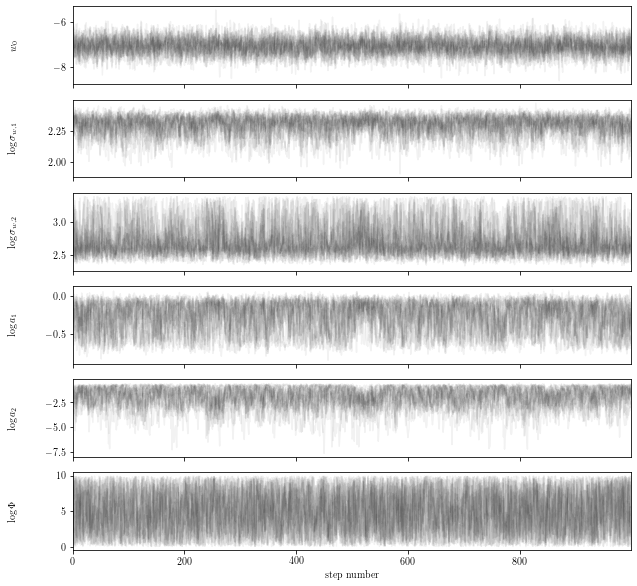

In [20]:
params = get_params(chain_thin, indexes, labs)

plot_chain().params(params).labels(labels).alpha(0.05).run()

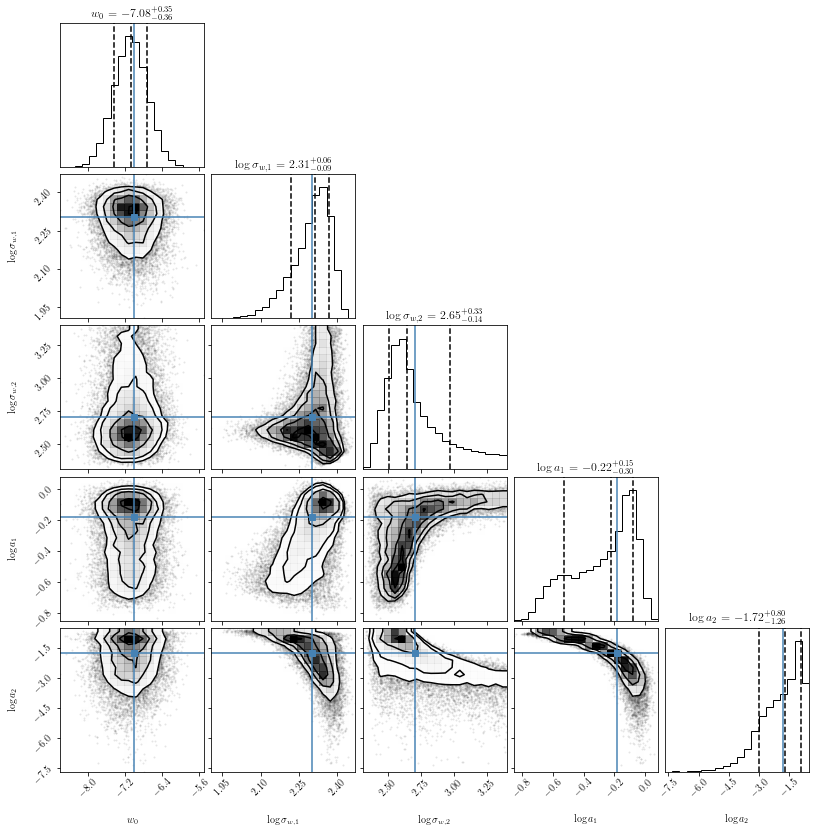

In [21]:
w0 = -7.
sigma1 = 10.
sigma2 = 15.
log_sigmaw1 = np.log(sigma1)
log_sigmaw2 = np.log(sigma2)

a1 = 1.
a2 = 0.2
atot = a1+a2
a1 /= atot
a2 /= atot
log_a1 = np.log(a1)
log_a2 = np.log(a2)
psi = np.array([w0, log_sigmaw1, log_sigmaw2, log_a1, log_a2])

params = get_params(chain_thin, indexes, labs)

plot_corner().params(params[:,:, :-1]).labels(labels[:-1]).truths(psi).run()

100%|██████████| 5000/5000 [00:00<00:00, 33667.88it/s]


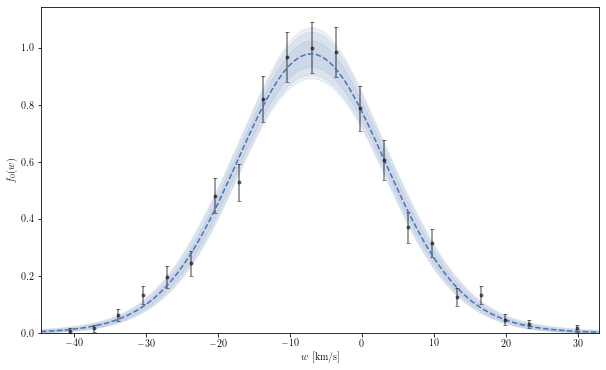

In [22]:
flat_samples = chain_thin.reshape(-1, ndim)

plot_fit_w().index(ind).w_dir_path(w_dir_path).flat(flat_samples).run()

## potential space

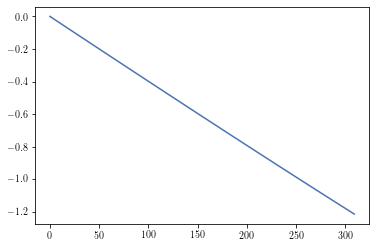

In [17]:
zdata = get_data(z_dir_path, ind, tipe="z")
zmid = zdata[0]
phi_max = np.max(np.abs(zmid))*2
phis = np.linspace(0.0001, phi_max, 21)
inds = np.random.randint(0, len(flat_samples), 5000)
log_sigmaw1 = flat_samples[inds[0], 1]
log_sigmaw2 = flat_samples[inds[0], 2]
log_a1 = flat_samples[inds[0], 3]
log_a2 = flat_samples[inds[0], 4]

sigmaw1 = np.exp(log_sigmaw1)
sigmaw2 = np.exp(log_sigmaw2)
a1 = np.exp(log_a1)
a2 = np.exp(log_a2)
atot = a1 + a2

nus = (a1*np.exp(-phis/sigmaw1**2) + a2*np.exp(-phis/sigmaw2**2))/atot

plt.plot(phis, np.log10(nus))
plt.show()

In [18]:
phis = np.linspace(0.0001, phi_max, 1000)
N = len(flat_samples)
print(N)
log_zmod_phi = np.empty((N, len(phis)))
for i in tqdm(range(N)):
    th = flat_samples[i]
    log_sigmaw1 = th[1]
    log_sigmaw2 = th[2]
    log_a1 = th[3]
    log_a2 = th[4]

    sigmaw1 = np.exp(log_sigmaw1)
    sigmaw2 = np.exp(log_sigmaw2)
    a1 = np.exp(log_a1)
    a2 = np.exp(log_a2)
    atot = a1 + a2
    zmod_phi_i = (a1*np.exp(-phis/sigmaw1**2)+a2*np.exp(-phis/sigmaw2**2))/atot
    log_zmod_phi[i] = np.log(zmod_phi_i)
log_zmod_phi

54000


100%|██████████| 54000/54000 [00:04<00:00, 12917.37it/s]


array([[-8.92093136e-07, -2.76064098e-03, -5.51961311e-03, ...,
        -2.40089357e+00, -2.40301547e+00, -2.40513696e+00],
       [-9.50061292e-07, -2.94019011e-03, -5.87892830e-03, ...,
        -2.64437593e+00, -2.64673001e+00, -2.64908353e+00],
       [-8.27191561e-07, -2.56010032e-03, -5.11925610e-03, ...,
        -2.49152582e+00, -2.49396385e+00, -2.49640176e+00],
       ...,
       [-8.45994765e-07, -2.61826915e-03, -5.23552075e-03, ...,
        -2.52620015e+00, -2.52865417e+00, -2.53110804e+00],
       [-1.00833080e-06, -3.12022832e-03, -6.23833412e-03, ...,
        -2.47423868e+00, -2.47612745e+00, -2.47801533e+00],
       [-9.73198476e-07, -3.01158688e-03, -6.02127327e-03, ...,
        -2.57784288e+00, -2.58008585e+00, -2.58232835e+00]])

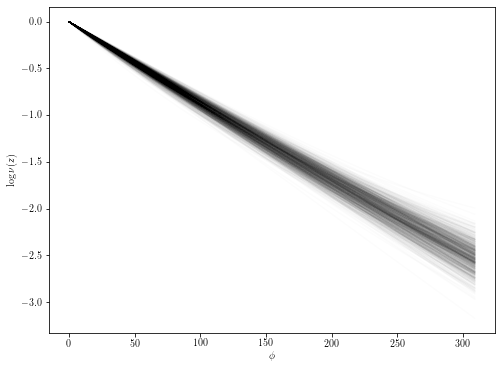

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(phis, log_zmod_phi[::60].T, 'k', alpha=0.01)
ax.set_xlabel(r'$\phi$')
ax.set_ylabel(r'$\log \nu(z)$')
plt.show()

<BarContainer object of 38 artists>

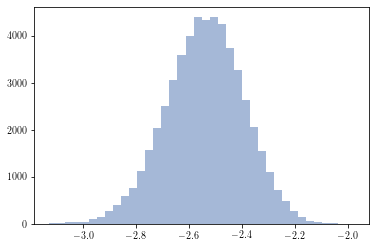

In [20]:
phi_i = 900
index = np.argmin(np.abs(phis-phi_i))
log_zmod_phi_i = log_zmod_phi[:, index]
med = np.median(log_zmod_phi_i)
mad = mad_func(log_zmod_phi_i)
mask = np.abs(log_zmod_phi_i-med) < 6*mad
log_zmod_phi_i = log_zmod_phi_i[mask]

low = med-6*mad
high = med+6*mad
yedge = np.linspace(low, high, 40)
dy = yedge[1]-yedge[0]
ymid = (yedge[1:]+yedge[:-1])/2
ynum, _ = np.histogram(log_zmod_phi_i, bins=yedge)
# ynum
mask = ynum > 0
ynum = ynum[mask]
ymid = ymid[mask]

# plot
plt.bar(ymid, ynum, width=dy, alpha=0.5)

In [21]:
med = np.median(log_zmod_phi, axis=0)
mad = mad_func(log_zmod_phi, axis=0)
partition = 50
pred = np.empty((len(phis), 2, partition))
for i, (log_zmod_phi_i, med_i, mad_i) in enumerate(zip(log_zmod_phi.T, med, tqdm(mad))):
    mask = np.abs(log_zmod_phi_i-med_i) < 6*mad_i
    log_zmod_phi_i = log_zmod_phi_i[mask]
    low = med_i-6*mad_i
    high = med_i+6*mad_i
    log_znum_edge = np.linspace(low, high, partition+1)
    dy = log_znum_edge[1]-log_znum_edge[0]
    log_znum_mod = (log_znum_edge[1:]+log_znum_edge[:-1])/2
    znum_weight, _ = np.histogram(log_zmod_phi_i, bins=log_znum_edge)
    total = znum_weight.sum()
    znum_weight = znum_weight/total
    pred_i = np.array([np.exp(log_znum_mod), znum_weight])
    pred[i] = pred_i

100%|█████████▉| 999/1000 [00:04<00:00, 238.74it/s]


In [22]:
name_pred

'pred_162.npy'

In [24]:
np.save(join(z_dir_path, 'PHI', name_pred), pred)
np.save(join(z_dir_path, 'PHI', name_phi), phis)

# Automate

In [35]:
from matplotlib import pyplot as plt
import numpy as np
from time import time
from os.path import abspath, join
import sys
from glob import glob
import vaex
from tqdm import tqdm
from hammer import vel
from scipy.stats import median_abs_deviation as mad_func
root_dir = abspath(join('..', '..'))
root_data_dir = join(root_dir, 'Data')
sys.path.append(root_dir)

In [36]:
from utils import (plot_corner, plot_chain, plot_fit_w, style, get_params,
                   get_initial_position_normal, get_data, generate_init)
style()

In [37]:
w_dir_path = join(root_data_dir, 'MCMC-no', 'mock', 'data', 'n')
z_dir_path = join(root_data_dir, 'MCMC-no', 'mock', 'data', 'n')
w_dir_path, z_dir_path

('/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/n',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/n')

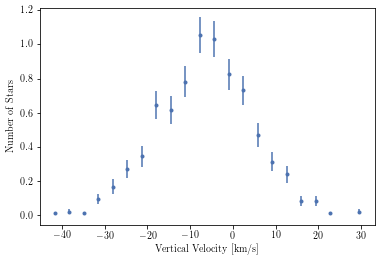

Running MCMC


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Running long mcmc


6it [00:00, 52.88it/s]


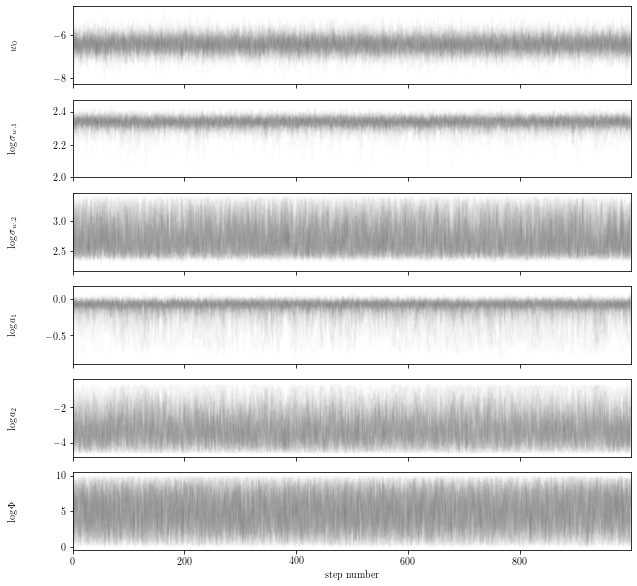

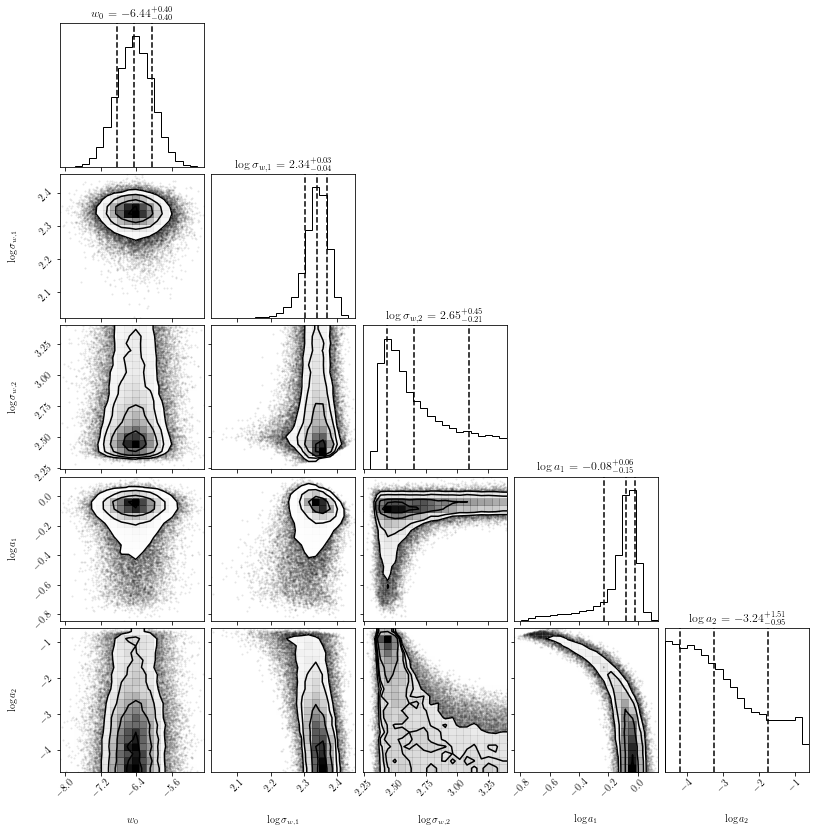

100%|██████████| 5000/5000 [00:00<00:00, 43617.43it/s]


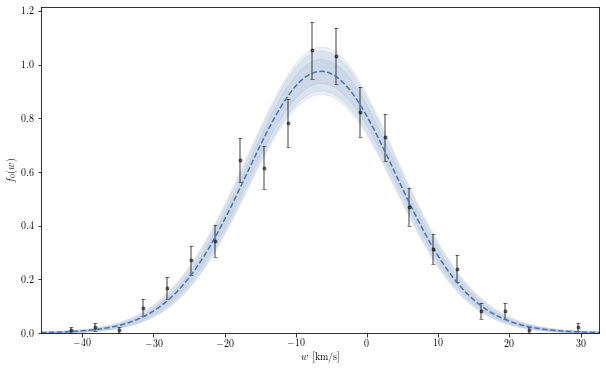

phi_max =  756.843202751174
52000


100%|██████████| 52000/52000 [00:04<00:00, 12415.48it/s]


med and mad...
calculate pred...


100%|█████████▉| 999/1000 [00:04<00:00, 242.06it/s]


saving...
done pred_01500.npy





Running MCMC


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Running long mcmc


6it [00:00, 49.36it/s]


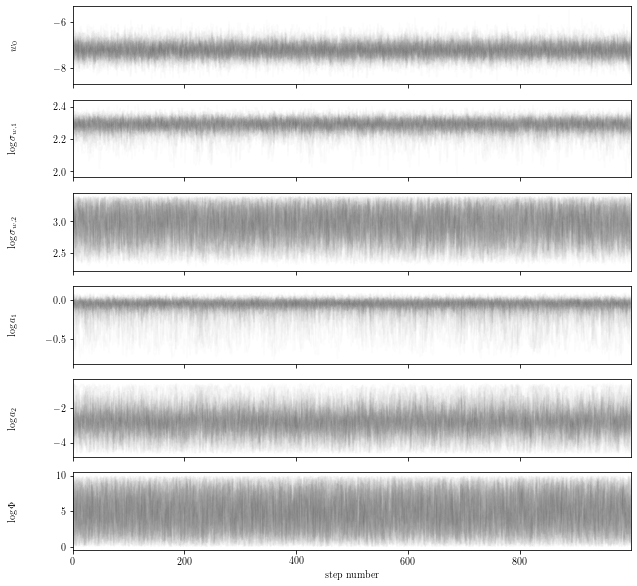

100%|██████████| 5000/5000 [00:00<00:00, 39628.65it/s]


phi_max =  756.6754099540462
56000


100%|██████████| 56000/56000 [00:04<00:00, 12378.85it/s]


med and mad...
calculate pred...


100%|█████████▉| 999/1000 [00:04<00:00, 217.06it/s]


saving...
done pred_02000.npy





Running MCMC


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Running long mcmc


6it [00:00, 43.00it/s]


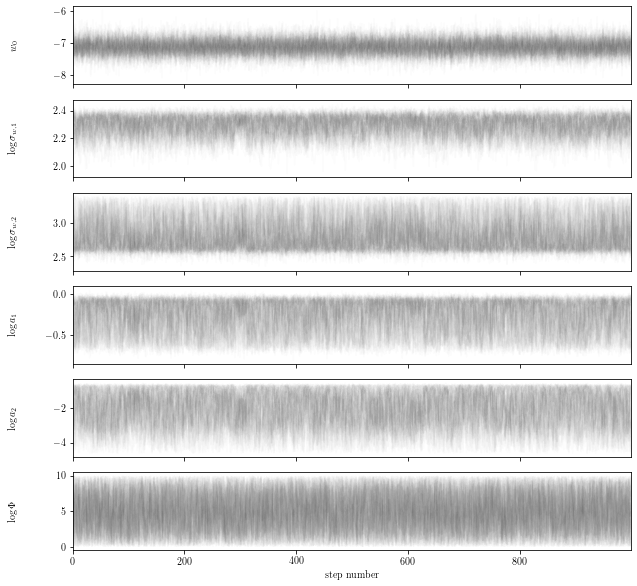

100%|██████████| 5000/5000 [00:00<00:00, 43493.05it/s]


phi_max =  755.2349402698982
60000


100%|██████████| 60000/60000 [00:04<00:00, 12636.29it/s]


med and mad...
calculate pred...


100%|█████████▉| 999/1000 [00:04<00:00, 209.24it/s]


saving...
done pred_05000.npy





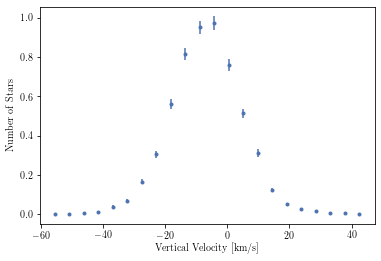

Running MCMC


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Running long mcmc


6it [00:00, 52.74it/s]


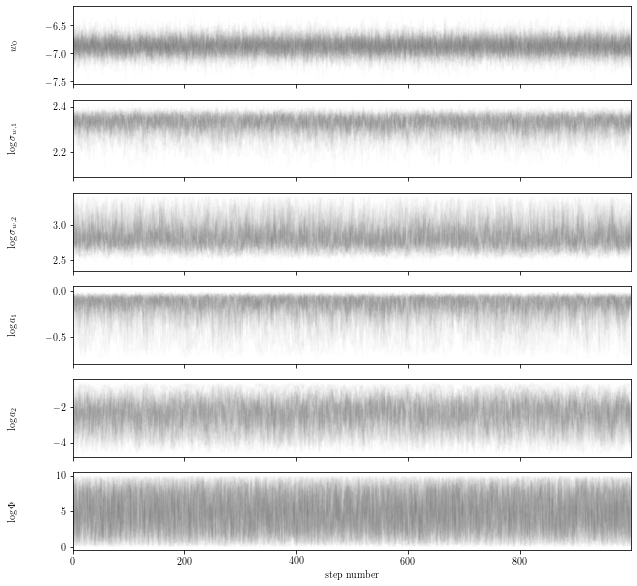

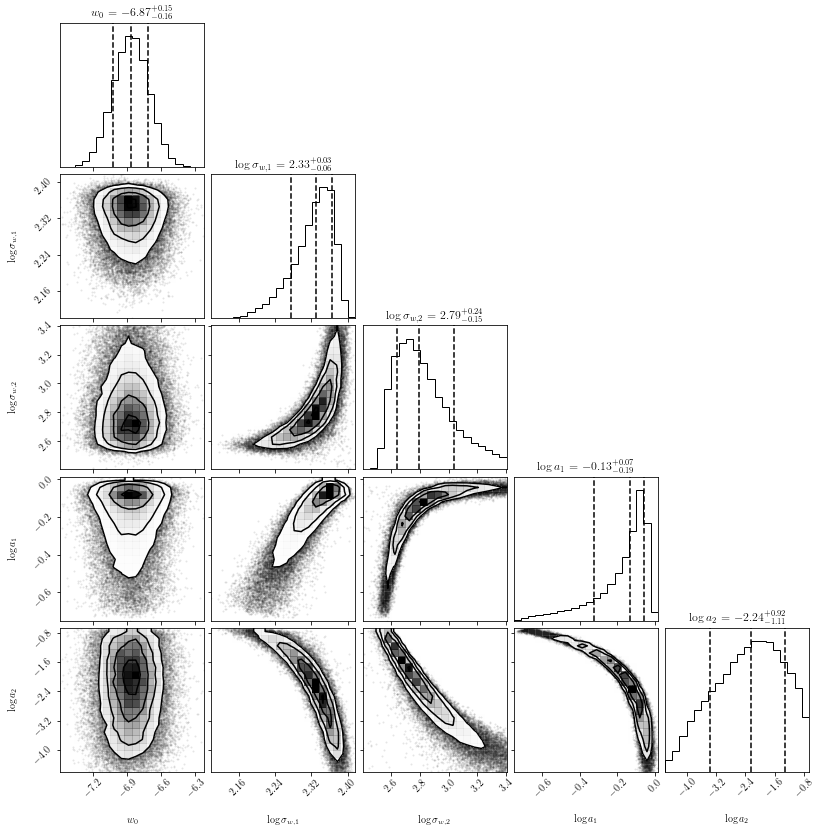

100%|██████████| 5000/5000 [00:00<00:00, 46109.29it/s]


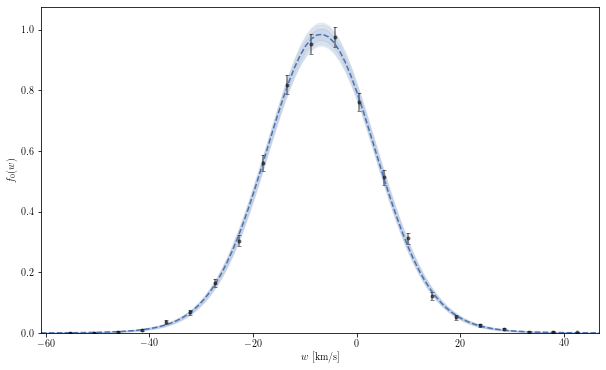

phi_max =  756.5483314318283
56000


100%|██████████| 56000/56000 [00:04<00:00, 12467.18it/s]


med and mad...
calculate pred...


100%|█████████▉| 999/1000 [00:04<00:00, 225.06it/s]


saving...
done pred_10000.npy





In [39]:
files = glob(join(z_dir_path, "w*"))
files.sort()
for ind in range(2, len(files)):
    wdata = get_data(w_dir_path, ind, "w")
    name_pred = files[ind].split(
        "/")[-1].split(".")[0].replace("w", "pred") + ".npy"
    name_phi = files[ind].split(
        "/")[-1].split(".")[0].replace("w", "phi") + ".npy"
    wmid, wnum, werr = wdata

    plt.errorbar(wmid, wnum, yerr=werr, fmt='.')
    plt.xlabel("Vertical Velocity [km/s]")
    plt.ylabel("Number of Stars")
    plt.show()

    psi, locs, scales, labels, labs = generate_init("kin")
    ndim = len(labs)
    nwalker = 10*ndim
    p0 = None
    while True:
        p0 = vel.generate_p0(nwalker, locs_normal, scales_normal, norm=True)
        prob0 = vel.log_prob_par(p0, wdata, locs, scales)
        mask = np.isinf(prob0[:, 0])
        p0 = p0[~mask]
        if p0.shape[0] % 2 != 0:
            p0 = np.append(p0, p0[0][None, :], axis=0)
        if p0.shape[0] >= 2*ndim:
            break
    print("Running MCMC")
    for _ in tqdm(range(5)):
        chain = vel.mcmc(5000, p0, wdata, locs, scales, parallel=True, verbose=True)
        locs_normal, scales_normal = get_initial_position_normal(
            "kin", chain=chain[2500:], indexes=indexes)
        while True:
          p0 = vel.generate_p0(nwalker, locs_normal, scales_normal, norm=True)
          prob0 = vel.log_prob_par(p0, wdata, locs, scales)
          mask = np.isinf(prob0[:, 0])
          p0 = p0[~mask]
          if p0.shape[0] % 2 != 0:
              p0 = np.append(p0, p0[0][None, :], axis=0)
          if p0.shape[0] >= 2*ndim:
              break
        chain = vel.mcmc(5000, p0, wdata, locs, scales, parallel=True, verbose=True)
        p0 = chain[-1]
    print("Running long mcmc")
    chain = vel.mcmc(100_000, p0, wdata, locs, scales,
                     parallel=True, verbose=True)
    chain_thin = chain[::100]
    params = get_params(chain_thin, indexes, labs)
    plot_chain().params(params).labels(labels).alpha(0.01).run()
    plot_corner().params(params[:,:,:-1]).labels(labels[:-1]).run()
    flat_samples = chain_thin.reshape(-1, ndim)
    plot_fit_w().index(ind).w_dir_path(w_dir_path).flat(flat_samples).run()
      
    zdata = get_data(z_dir_path, ind, "z")
    phi_max = np.max(np.abs(zdata[0]))*2
    print("phi_max = ", phi_max)
    # potential space
    phis = np.linspace(0.0001, phi_max, 1000)
    N = len(flat_samples)
    print(N)
    log_zmod_phi = np.empty((N, len(phis)))
    for i in tqdm(range(N)):
        th = flat_samples[i]
        log_sigmaw1 = th[1]
        log_sigmaw2 = th[2]
        log_a1 = th[3]
        log_a2 = th[4]

        sigmaw1 = np.exp(log_sigmaw1)
        sigmaw2 = np.exp(log_sigmaw2)
        a1 = np.exp(log_a1)
        a2 = np.exp(log_a2)
        atot = a1 + a2
        zmod_phi_i = (a1*np.exp(-phis/sigmaw1**2) +
                      a2*np.exp(-phis/sigmaw2**2))/atot
        log_zmod_phi[i] = np.log(zmod_phi_i)
    print("med and mad...")
    med = np.median(log_zmod_phi, axis=0)
    mad = mad_func(log_zmod_phi, axis=0)
    partition = 50
    pred = np.empty((len(phis), 2, partition))
    print("calculate pred...")
    for i, (log_zmod_phi_i, med_i, mad_i) in enumerate(zip(log_zmod_phi.T, med, tqdm(mad))):
        mask = np.abs(log_zmod_phi_i-med_i) < 6*mad_i
        log_zmod_phi_i = log_zmod_phi_i[mask]
        low = med_i-6*mad_i
        high = med_i+6*mad_i
        log_znum_edge = np.linspace(low, high, partition+1)
        dy = log_znum_edge[1]-log_znum_edge[0]
        log_znum_mod = (log_znum_edge[1:]+log_znum_edge[:-1])/2
        znum_weight, _ = np.histogram(log_zmod_phi_i, bins=log_znum_edge)
        total = znum_weight.sum()
        znum_weight = znum_weight/total
        pred_i = np.array([np.exp(log_znum_mod), znum_weight])
        pred[i] = pred_i
    print("saving...")
    np.save(join(z_dir_path, 'PHI', name_pred), pred)
    np.save(join(z_dir_path, 'PHI', name_phi), phis)
    print("done", name_pred)
    print("\n\n")
    # break

# comparison data

In [7]:
from matplotlib import pyplot as plt
import numpy as np
from time import time
from os.path import abspath, join
import sys
from glob import glob
import vaex
from tqdm import tqdm
from hammer import vel
from scipy.stats import median_abs_deviation as mad_func
root_dir = abspath(join('..', '..'))
root_data_dir = join(root_dir, 'Data')
sys.path.append(root_dir)

In [8]:
from utils import (plot_corner, plot_chain, plot_fit_w, style, get_params,
                   get_initial_position_normal, get_data, generate_init)
style()

In [9]:
w_dir_path = join(root_data_dir, 'MCMC-no', 'mock', 'data', 'mock')
z_dir_path = join(root_data_dir, 'MCMC-no', 'mock', 'data', 'mock')
w_dir_path, z_dir_path

('/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/mock',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/mock')

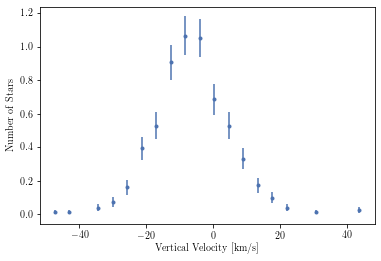

Running MCMC


100%|██████████| 5/5 [00:21<00:00,  4.30s/it]


Running long mcmc


6it [00:00, 30.74it/s]


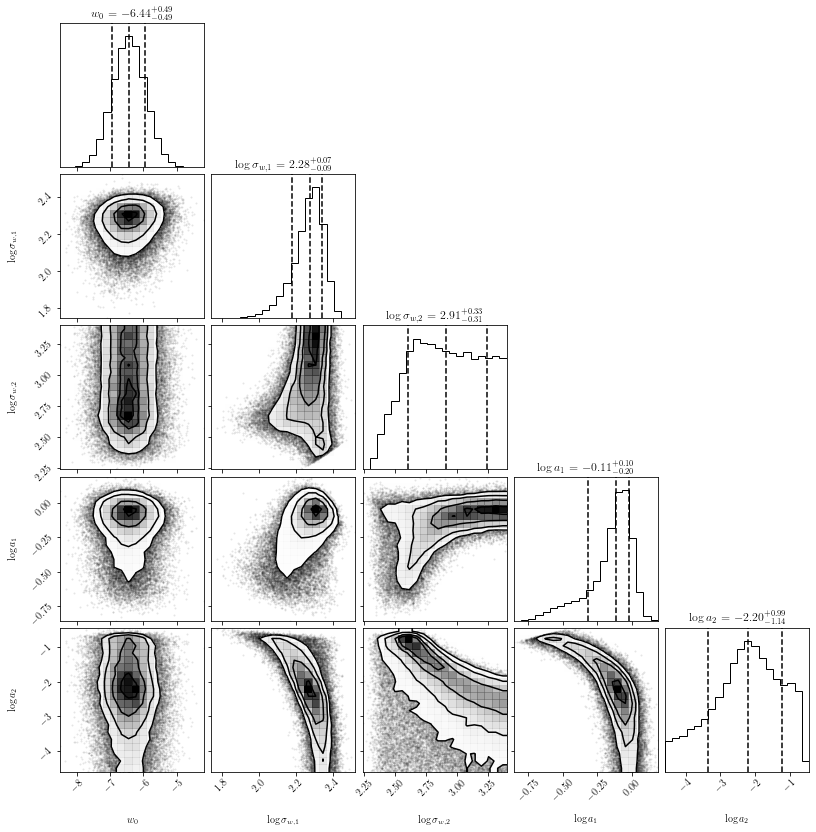

100%|██████████| 5000/5000 [00:00<00:00, 25603.91it/s]


phi_max =  756.4886767761461
56000


100%|██████████| 56000/56000 [00:09<00:00, 6165.17it/s]


med and mad...
calculate pred...


100%|█████████▉| 999/1000 [00:07<00:00, 140.21it/s]


saving...
done pred_0001000.npy





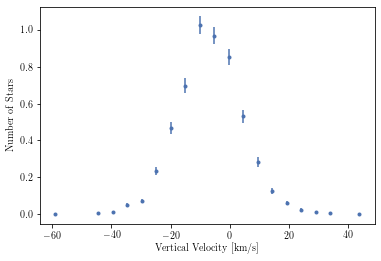

Running MCMC


100%|██████████| 5/5 [00:22<00:00,  4.53s/it]


Running long mcmc


6it [00:00, 27.62it/s]


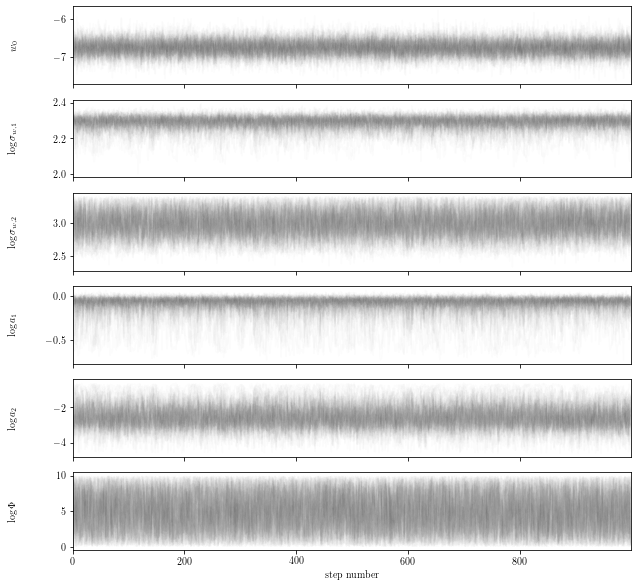

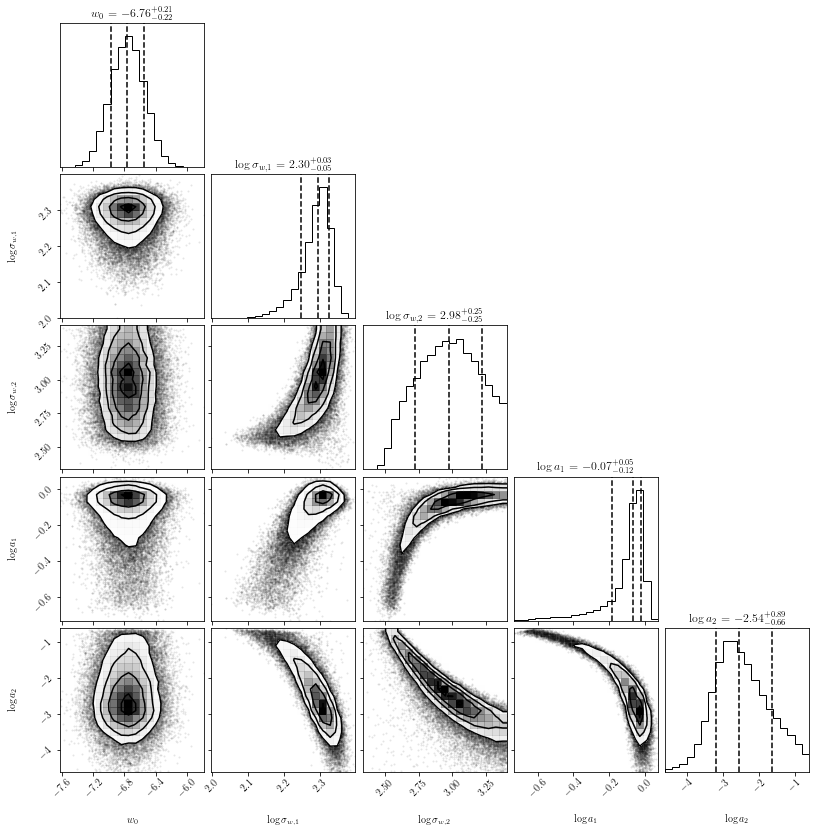

100%|██████████| 5000/5000 [00:00<00:00, 18565.24it/s]


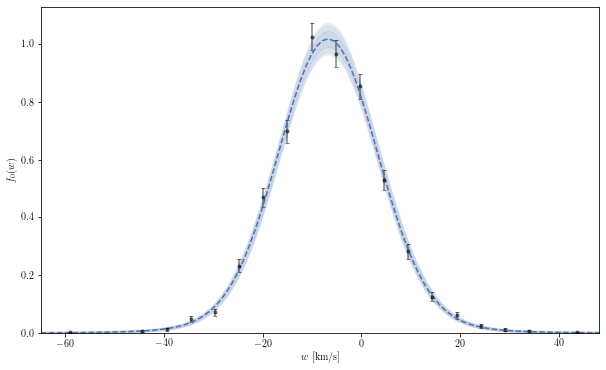

phi_max =  756.4936229649268
56000


100%|██████████| 56000/56000 [00:09<00:00, 6205.32it/s]


med and mad...
calculate pred...


100%|█████████▉| 999/1000 [00:07<00:00, 140.53it/s]


saving...
done pred_0005000.npy





Running MCMC


100%|██████████| 5/5 [00:23<00:00,  4.72s/it]


Running long mcmc


6it [00:00, 15.60it/s]


100%|██████████| 5000/5000 [00:00<00:00, 26885.39it/s]


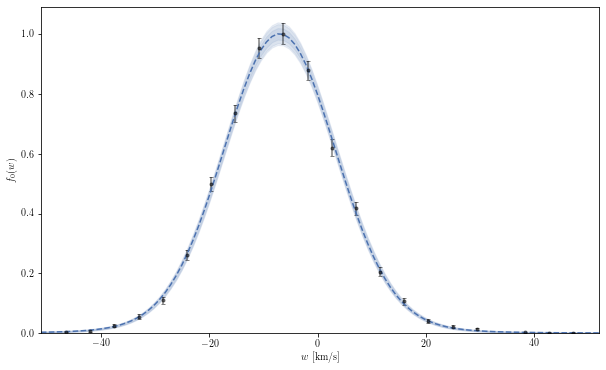

phi_max =  756.6683212613416
56000


100%|██████████| 56000/56000 [00:08<00:00, 6250.25it/s]


med and mad...
calculate pred...


100%|█████████▉| 999/1000 [00:06<00:00, 147.00it/s]

saving...
done pred_0010000.npy





In [10]:
files = glob(join(w_dir_path, "w*"))
files.sort()
for ind in range(3):
    wdata = get_data(w_dir_path, ind, "w")
    name_pred = files[ind].split(
        "/")[-1].split(".")[0].replace("w", "pred") + ".npy"
    name_phi = files[ind].split(
        "/")[-1].split(".")[0].replace("w", "phi") + ".npy"
    wmid, wnum, werr = wdata

    plt.errorbar(wmid, wnum, yerr=werr, fmt='.')
    plt.xlabel("Vertical Velocity [km/s]")
    plt.ylabel("Number of Stars")
    plt.show()

    psi, locs, scales, labels, labs = generate_init("kin")
    ndim = len(labs)
    indexes = list(range(ndim))
    nwalker = 10*ndim
    p0 = None
    while True:
        p0 = vel.generate_p0(5*nwalker, locs, scales)
        prob0 = vel.log_prob_par(p0, wdata, locs, scales)
        mask = np.isinf(prob0[:, 0])
        p0 = p0[~mask]
        if p0.shape[0] % 2 != 0:
            p0 = np.append(p0, p0[0][None, :], axis=0)
        if p0.shape[0] >= 2*ndim:
            break
    print("Running MCMC")
    for _ in tqdm(range(5)):
        chain = vel.mcmc(5000, p0, wdata, locs, scales, parallel=True, verbose=True)
        locs_normal, scales_normal = get_initial_position_normal(
            "kin", chain=chain[2500:], indexes=indexes)
        while True:
          p0 = vel.generate_p0(nwalker, locs_normal, scales_normal, norm=True)
          prob0 = vel.log_prob_par(p0, wdata, locs, scales)
          mask = np.isinf(prob0[:, 0])
          p0 = p0[~mask]
          if p0.shape[0] % 2 != 0:
              p0 = np.append(p0, p0[0][None, :], axis=0)
          if p0.shape[0] >= 2*ndim:
              break
        chain = vel.mcmc(5000, p0, wdata, locs, scales, parallel=True, verbose=True)
        p0 = chain[-1]
    print("Running long mcmc")
    chain = vel.mcmc(100_000, p0, wdata, locs, scales,
                     parallel=True, verbose=True)
    chain_thin = chain[::100]
    params = get_params(chain_thin, indexes, labs)
    plot_chain().params(params).labels(labels).alpha(0.01).run()
    plot_corner().params(params[:,:,:-1]).labels(labels[:-1]).run()
    flat_samples = chain_thin.reshape(-1, ndim)
    plot_fit_w().index(ind).w_dir_path(w_dir_path).flat(flat_samples).run()
      
    zdata = get_data(z_dir_path, ind, "z")
    phi_max = np.max(np.abs(zdata[0]))*2
    print("phi_max = ", phi_max)
    # potential space
    phis = np.linspace(0.0001, phi_max, 1000)
    N = len(flat_samples)
    print(N)
    log_zmod_phi = np.empty((N, len(phis)))
    for i in tqdm(range(N)):
        th = flat_samples[i]
        log_sigmaw1 = th[1]
        log_sigmaw2 = th[2]
        log_a1 = th[3]
        log_a2 = th[4]

        sigmaw1 = np.exp(log_sigmaw1)
        sigmaw2 = np.exp(log_sigmaw2)
        a1 = np.exp(log_a1)
        a2 = np.exp(log_a2)
        atot = a1 + a2
        zmod_phi_i = (a1*np.exp(-phis/sigmaw1**2) +
                      a2*np.exp(-phis/sigmaw2**2))/atot
        log_zmod_phi[i] = np.log(zmod_phi_i)
    print("med and mad...")
    med = np.median(log_zmod_phi, axis=0)
    mad = mad_func(log_zmod_phi, axis=0)
    partition = 50
    pred = np.empty((len(phis), 2, partition))
    print("calculate pred...")
    for i, (log_zmod_phi_i, med_i, mad_i) in enumerate(zip(log_zmod_phi.T, med, tqdm(mad))):
        mask = np.abs(log_zmod_phi_i-med_i) < 6*mad_i
        log_zmod_phi_i = log_zmod_phi_i[mask]
        low = med_i-6*mad_i
        high = med_i+6*mad_i
        log_znum_edge = np.linspace(low, high, partition+1)
        dy = log_znum_edge[1]-log_znum_edge[0]
        log_znum_mod = (log_znum_edge[1:]+log_znum_edge[:-1])/2
        znum_weight, _ = np.histogram(log_zmod_phi_i, bins=log_znum_edge)
        total = znum_weight.sum()
        znum_weight = znum_weight/total
        pred_i = np.array([np.exp(log_znum_mod), znum_weight])
        pred[i] = pred_i
    print("saving...")
    np.save(join(z_dir_path, name_pred), pred)
    np.save(join(z_dir_path, name_phi), phis)
    print("done", name_pred)
    print("\n\n")
    # break